In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from PIL import Image

csoupdata = pd.read_csv("./final_file.csv",sep=",",encoding='utf-8',\
                        usecols=[3,4,6,8,9])
                        
csoupdata.head()


,car_make,car_model,car_year,car_mileage,car_price
0,Toyota,Corolla-LE,2015,23036,13298
1,Jeep,Wrangler-Unlimted-Sahara,2012,73619,26995
2,Honda,Civic-LX,2014,27784,14097
3,Jeep,Grand-Cherokee-Limited,2014,36636,27899
4,Hyundai,Santa-Fe-Sport-24L,2013,48568,18981


In [2]:
#SELECTING single model
car_make_forPrediction = "Hyundai"
car_model_forPrediction = "Sonata-GLS"
car_year_forPrediction = 2014

#number of iterations to obtain samples
niter = 10000

# DataFrame with only data for the selected car_make
selected_data = csoupdata[(csoupdata.car_make == car_make_forPrediction) &\
                          (csoupdata.car_model == car_model_forPrediction) &\
                           (csoupdata.car_year == car_year_forPrediction) &\
                         (csoupdata.car_mileage < 100000) ] # Removing and outlier from the data
selected_data.head()

,car_make,car_model,car_year,car_mileage,car_price
27,Hyundai,Sonata-GLS,2014,37344,9988
273,Hyundai,Sonata-GLS,2014,43660,9988
538,Hyundai,Sonata-GLS,2014,8558,13993
682,Hyundai,Sonata-GLS,2014,23094,11597
898,Hyundai,Sonata-GLS,2014,5818,14998


In [3]:
selected_data.describe()

,car_year,car_mileage,car_price
count,114.0,114.000000,114.000000
mean,2014.0,26957.815789,13285.210526
std,0.0,11004.709486,1595.210256
min,2014.0,5516.000000,9988.000000
25%,2014.0,20001.750000,11988.000000
50%,2014.0,26242.000000,13512.500000
75%,2014.0,34921.750000,13999.500000
max,2014.0,59201.000000,17999.000000


#Plotting simple linear regression

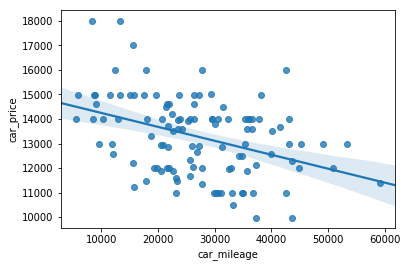

In [4]:

sns.regplot(x='car_mileage',y='car_price',data=selected_data)

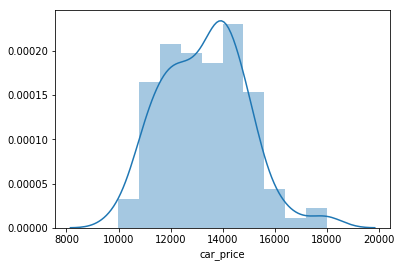

In [5]:
sns.distplot(selected_data.car_price)


#Model Creation and Plotting
    Y ∼ N(μ,σ2)
    μ = α + βX #price_est

    Y ==> Price RV #price_like
    X ==> Mileage 

    α ∼ Normal Dist #intercept_year_overall
    β ∼ Normal Dist #miles_year_overal
    σ ~ Uniform Dist #model_error


In [6]:

from pymc3 import *
num_years = len(selected_data.car_price)

with pm.Model() as price_ymm:
    
        # Stochastic Random Variables with Random Distribution
        intercept_mu = selected_data.car_price.mean()
        intercept_year_mean = pm.Normal('intercept_year_mean', mu=intercept_mu, sd=10000.)
        intercept_year_sd = pm.Normal('intercept_year_sd',mu=intercept_mu, sd=10000.)
        intercept_year_overall = pm.Normal('intercept_year_overall',
                                           mu=intercept_year_mean, sd=intercept_year_sd,shape=num_years)

        miles_year_mean = pm.Normal('miles_year_mean', mu=0, sd=10000.)
        miles_year_sd = pm.Gamma('miles_year_sd', mu=0.0001, sd=10000.)
        #miles distribuitions
        miles_year_overall = pm.Normal('miles_year_overall',mu=miles_year_mean,
                                        sd=miles_year_sd,shape=num_years)
    

        price_est = intercept_year_overall + miles_year_overall * selected_data.car_mileage
        
        # model error
        model_error = pm.Uniform('model_error', lower=0, upper=100000)

        # calculate likelihood
        price_like = pm.Normal('price_like', mu=price_est, sd=model_error, observed=selected_data.car_price)

        # Sampling method to generate posterior sample
        step = pm.Metropolis()
        trace = pm.sample(niter,step=step)

100%|██████████| 10500/10500 [00:15<00:00, 688.55it/s]


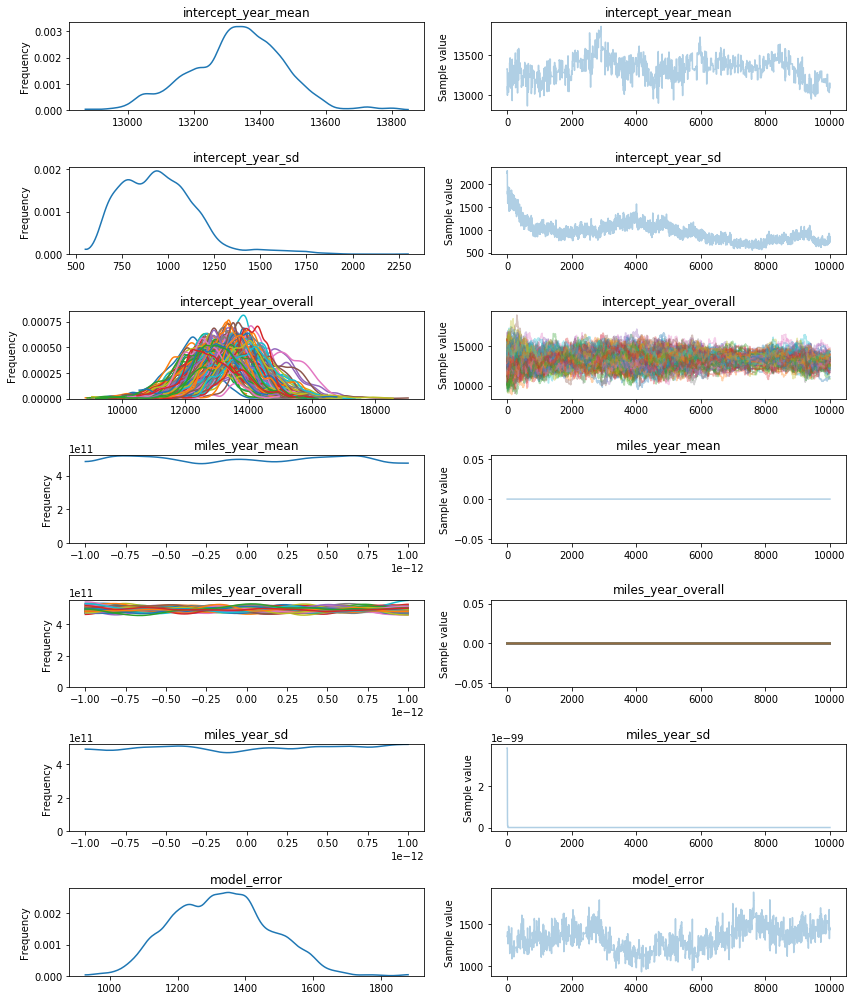

In [7]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();


In [8]:
#pm.summary(trace)


100%|██████████| 10/10 [00:00<00:00, 64.85it/s]


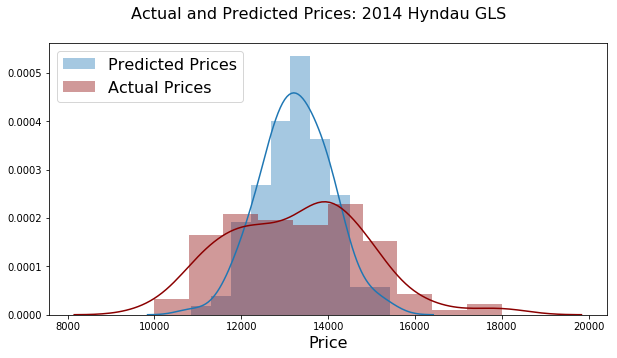

In [9]:
ppc = pm.sample_ppc(trace, model=price_ymm,samples=10)
pred_prices = np.mean(ppc['price_like'],axis=0)

fig,ax = plt.subplots(figsize=(10,5),sharex=True)

fig.suptitle('Actual and Predicted Prices: 2014 Hyndau GLS',fontsize=16)
# predicted
sns.distplot(pred_prices,label='Predicted Prices')

# actual
sns.distplot(selected_data.car_price,color='darkred',label='Actual Prices')
plt.xlabel('Price',fontsize=16)
plt.legend(loc='upper left',fontsize=16)

plt.show()


In [12]:
#Reference: https://github.com/clrife/CarPriceAnalysis/blob/master/CarPriceAnalysis_Technical.ipynb